https://www.bgc-jena.mpg.de/wetter/

https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [1]:
# import required libraries

# data preprocessing
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# visualization
from matplotlib import pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 6.0)

# implementing deep learning model
import tensorflow as ts
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import load_model 

In [2]:
data = pd.read_csv("mpi_roof\mpi_roof.csv",encoding= 'unicode_escape')
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31931 entries, 0 to 31930
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time             31931 non-null  object 
 1   p (mbar)              31931 non-null  float64
 2   T (degC)              31931 non-null  float64
 3   Tpot (K)              31931 non-null  float64
 4   Tdew (degC)           31931 non-null  float64
 5   rh (%)                31931 non-null  float64
 6   VPmax (mbar)          31931 non-null  float64
 7   VPact (mbar)          31931 non-null  float64
 8   VPdef (mbar)          31931 non-null  float64
 9   sh (g/kg)             31931 non-null  float64
 10  H2OC (mmol/mol)       31931 non-null  float64
 11  rho (g/m**3)          31931 non-null  float64
 12  wv (m/s)              31931 non-null  float64
 13  max. wv (m/s)         31931 non-null  float64
 14  wd (deg)              31931 non-null  float64
 15  rain (mm)          

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
count,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,...,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000,31931.000000
mean,990.646484,10.966426,284.885015,6.840672,79.511083,15.146275,10.647325,4.498847,6.718122,10.750479,...,2.057666,3.385259,172.644516,0.009580,31.957032,106.328058,208.339513,250.871895,19.939707,424.905399
std,8.268963,8.751587,8.807894,6.027105,19.419032,8.942102,4.077635,6.807391,2.587192,4.123436,...,1.448510,2.203478,83.729286,0.167079,123.946813,193.646628,376.554554,479.030428,8.154881,303.832296
min,955.430000,-13.390000,259.340000,-14.190000,14.230000,2.170000,2.030000,0.000000,1.260000,2.020000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.410000,-9999.000000
25%,985.930000,4.610000,278.640000,2.890000,68.700000,8.490000,7.520000,0.290000,4.730000,7.590000,...,0.990000,1.750000,119.500000,0.000000,0.000000,0.000000,0.000000,0.000000,13.630000,420.100000
50%,991.160000,11.070000,285.160000,7.330000,84.200000,13.200000,10.250000,1.820000,6.470000,10.360000,...,1.710000,2.850000,195.100000,0.000000,0.000000,0.000000,0.000000,0.000000,19.150000,430.100000
75%,995.540000,17.025000,290.870000,11.465000,96.200000,19.435000,13.560000,5.580000,8.550000,13.680000,...,2.740000,4.490000,224.950000,0.000000,0.000000,121.430000,241.275000,288.995000,25.195000,444.300000
max,1014.630000,37.950000,312.210000,19.720000,100.000000,66.130000,23.010000,56.720000,14.670000,23.380000,...,12.810000,17.820000,360.000000,19.200000,600.000000,1044.180000,2026.210000,2485.400000,45.800000,530.200000


In [3]:
data.drop_duplicates(inplace=True)
data.reset_index(inplace=True,drop=True)
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
0,01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
1,01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
2,01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
3,01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
4,01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


In [4]:
data["Date"] = pd.to_datetime(data["Date Time"])

# data["Date"] = data["Date Time"].astype("datetime64[ns]")
data["Date"].shape

(31930,)

In [5]:
data.set_index("Date Time",inplace=True)
data.drop("Date",axis=1,inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC),CO2 (ppm)
Date Time,,,,,,,,,,,,,,,,,,,,,
01.07.2022 00:10:00,984.33,22.42,296.91,19.72,84.7,27.17,23.01,4.16,14.67,23.38,...,1.18,1.63,219.9,0.0,0,0.0,0.0,0.0,31.74,447.2
01.07.2022 00:20:00,984.36,22.02,296.50,19.72,86.8,26.51,23.01,3.50,14.67,23.38,...,1.02,1.58,222.4,0.0,0,0.0,0.0,0.0,31.63,445.6
01.07.2022 00:30:00,984.35,21.77,296.25,19.68,87.9,26.11,22.95,3.16,14.63,23.32,...,0.99,1.64,191.0,0.0,0,0.0,0.0,0.0,31.52,443.1
01.07.2022 00:40:00,984.27,22.00,296.49,19.47,85.6,26.48,22.67,3.81,14.45,23.03,...,1.45,2.40,211.8,0.0,0,0.0,0.0,0.0,31.44,443.4
01.07.2022 00:50:00,984.36,22.23,296.71,19.40,84.0,26.86,22.56,4.30,14.38,22.92,...,1.66,2.59,211.9,0.0,0,0.0,0.0,0.0,31.37,444.4


In [6]:
# feature selection
data_selected = data.iloc[:, [0,1,4,8,16,20]]
display(data_selected.head())

,p (mbar),T (degC),rh (%),sh (g/kg),SWDR (W/m²),CO2 (ppm)
Date Time,,,,,,
01.07.2022 00:10:00,984.33,22.42,84.7,14.67,0.0,447.2
01.07.2022 00:20:00,984.36,22.02,86.8,14.67,0.0,445.6
01.07.2022 00:30:00,984.35,21.77,87.9,14.63,0.0,443.1
01.07.2022 00:40:00,984.27,22.00,85.6,14.45,0.0,443.4
01.07.2022 00:50:00,984.36,22.23,84.0,14.38,0.0,444.4


In [7]:
col_names = list(data_selected.columns)
colors = ['b','g','r','c','m','y']

In [8]:
# for i in range(data_selected.shape[1]):
#     plt.figure(figsize=(15,6))
#     plt.plot(data_selected.iloc[:,i],color=colors[i])
#     plt.title(col_names[i])
#     plt.show()

In [9]:
# scale data
scaler = MinMaxScaler(feature_range=(-1,1))
data_scaled = scaler.fit_transform(data_selected)


In [10]:
# train and test split
from math import ceil
test_size = 1008
train = data_scaled[:-test_size,:]
test = data_scaled[-test_size:,:]


In [11]:
print(train.size)
print(test.size)

185532
6048


In [12]:
def plot_histogram(y,x,train,column_names,colors):
    plt.figure(figsize=(20,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.hist(train[:,i],color=colors[i])
        plt.title(col_names[i])

    plt.show()

In [13]:
def plot_boxplot(y,x,train,column_names,colors):
    plt.figure(figsize=(20,20))
    for i in range(train.shape[1]):
        plt.subplot(y,x,i+1)
        plt.boxplot(train[:,i])
        plt.title(col_names[i])

    plt.show()

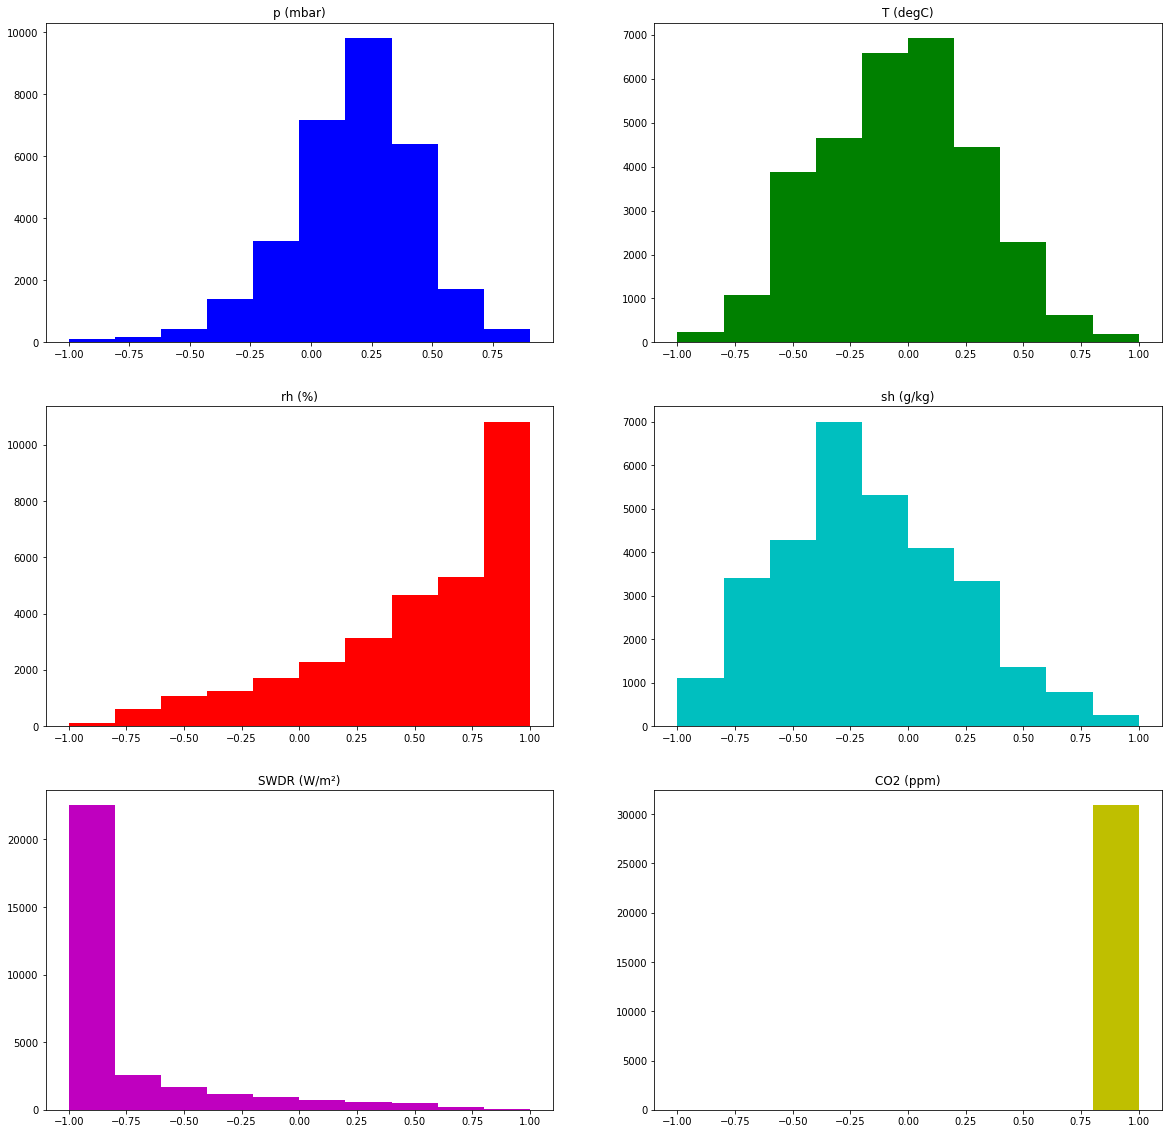

In [14]:
plot_histogram(3,2,train,col_names,colors)

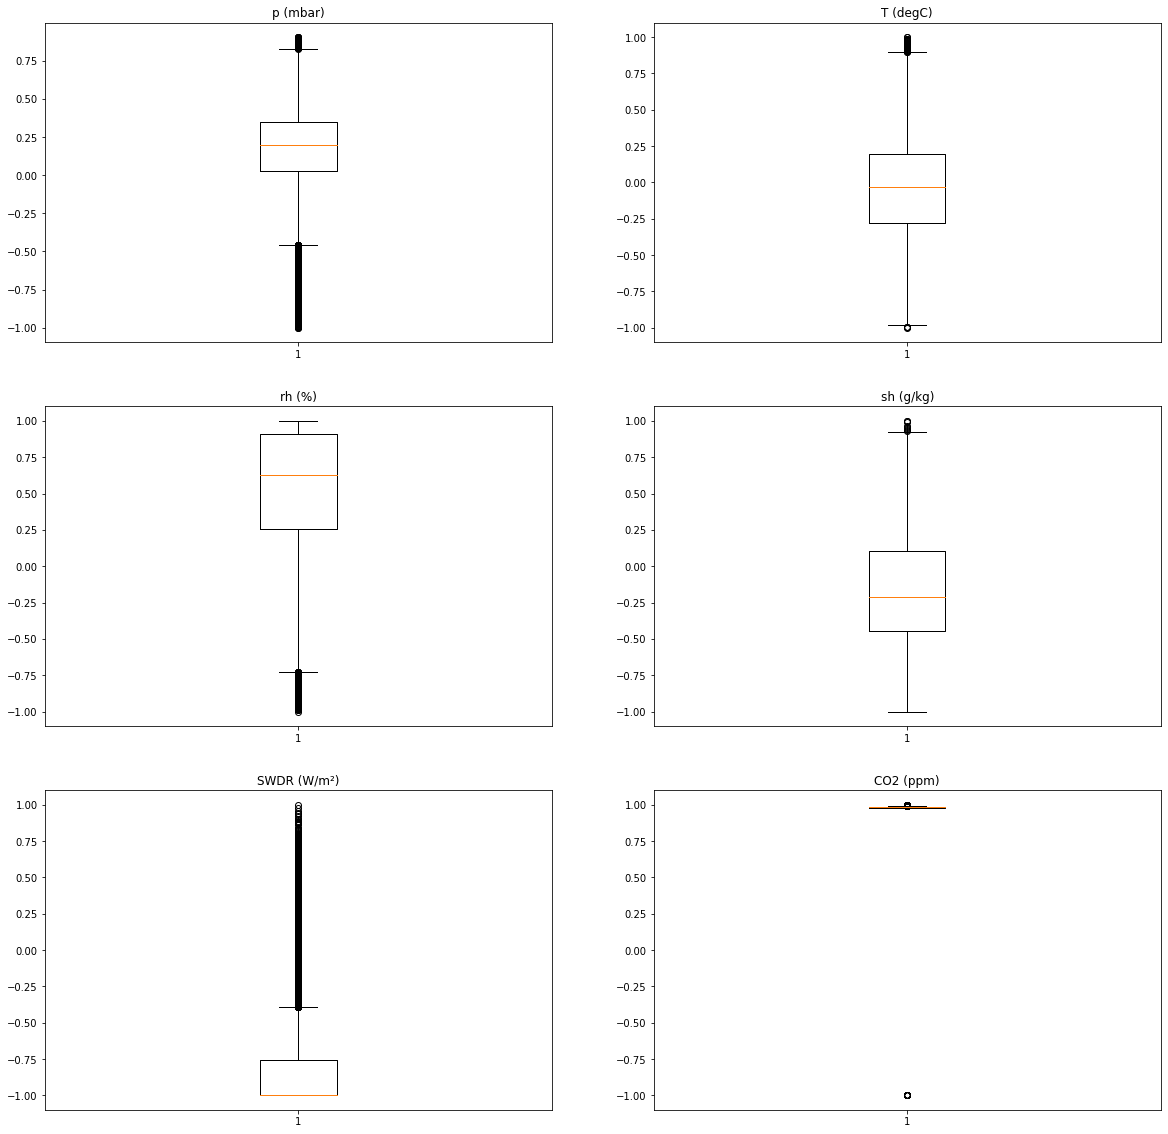

In [15]:
plot_boxplot(3,2,train,col_names,colors)

In [16]:
def remove_anomaly(train,index,anomaly_idx_list):
    for i in range(len(anomaly_idx_list)):
        size = 0
        mean = 0
        for j in range(anomaly_idx_list[i]-100,anomaly_idx_list[i]+101):
            if(train.shape[0]-101>=j>=0 and j not in anomaly_idx_list ):
                size += 1
                mean += train[j,index]
#         print(mean/size)
        if size != 0:
            train[anomaly_idx_list[i],index] = mean/size
    return train

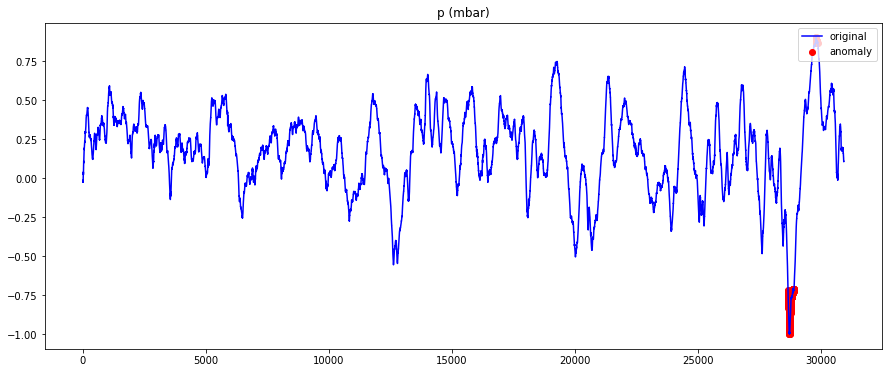

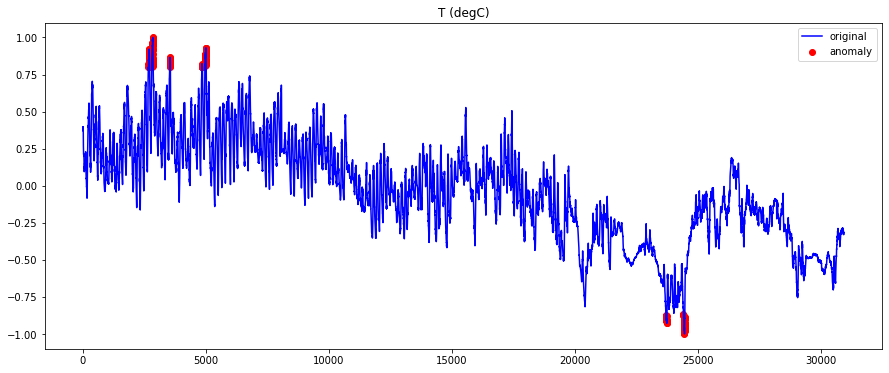

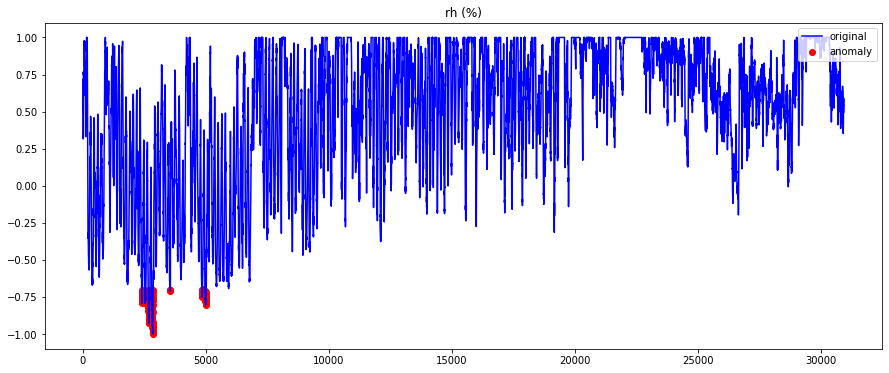

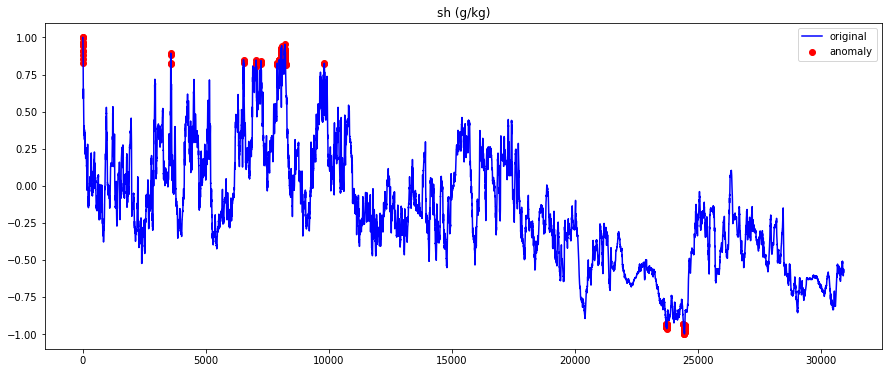

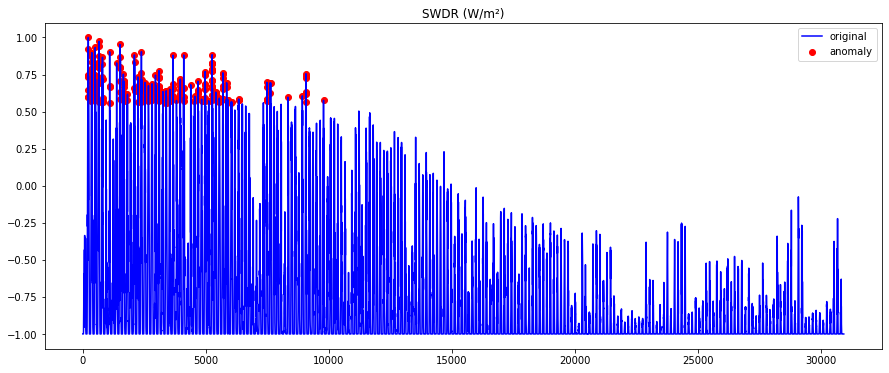

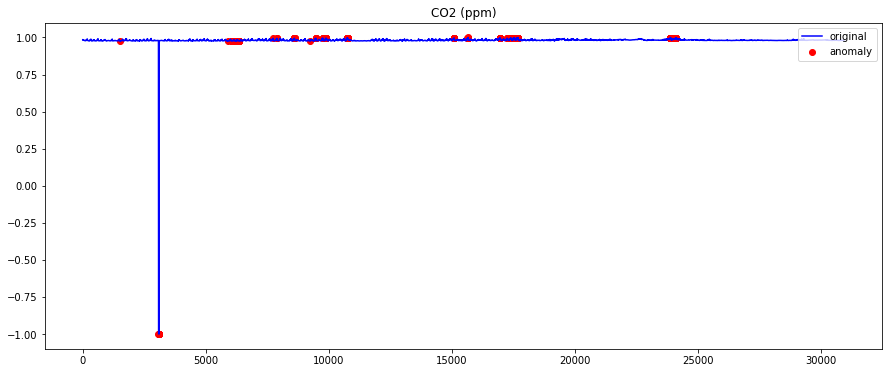

In [17]:
isolation_forest = IsolationForest(contamination=0.01)

for idx in range(train.shape[1]):
    dt_feature = [[item] for item in train[:,idx]]
    isolation_forest.fit(dt_feature)
    pred = isolation_forest.predict(dt_feature)
    anomaly = [i for i in range(len(pred)) if pred[i] == -1]
    
    train = remove_anomaly(train,idx,anomaly)
    
    anomaly_val = []
    for i in range(len(anomaly)):
        anomaly_val.append(dt_feature[anomaly[i]])
    plt.plot(dt_feature,color='b')
    plt.title(col_names[idx])
    plt.scatter(anomaly,anomaly_val,color='r')
    plt.legend(['original','anomaly'], loc='upper right')
    plt.show()



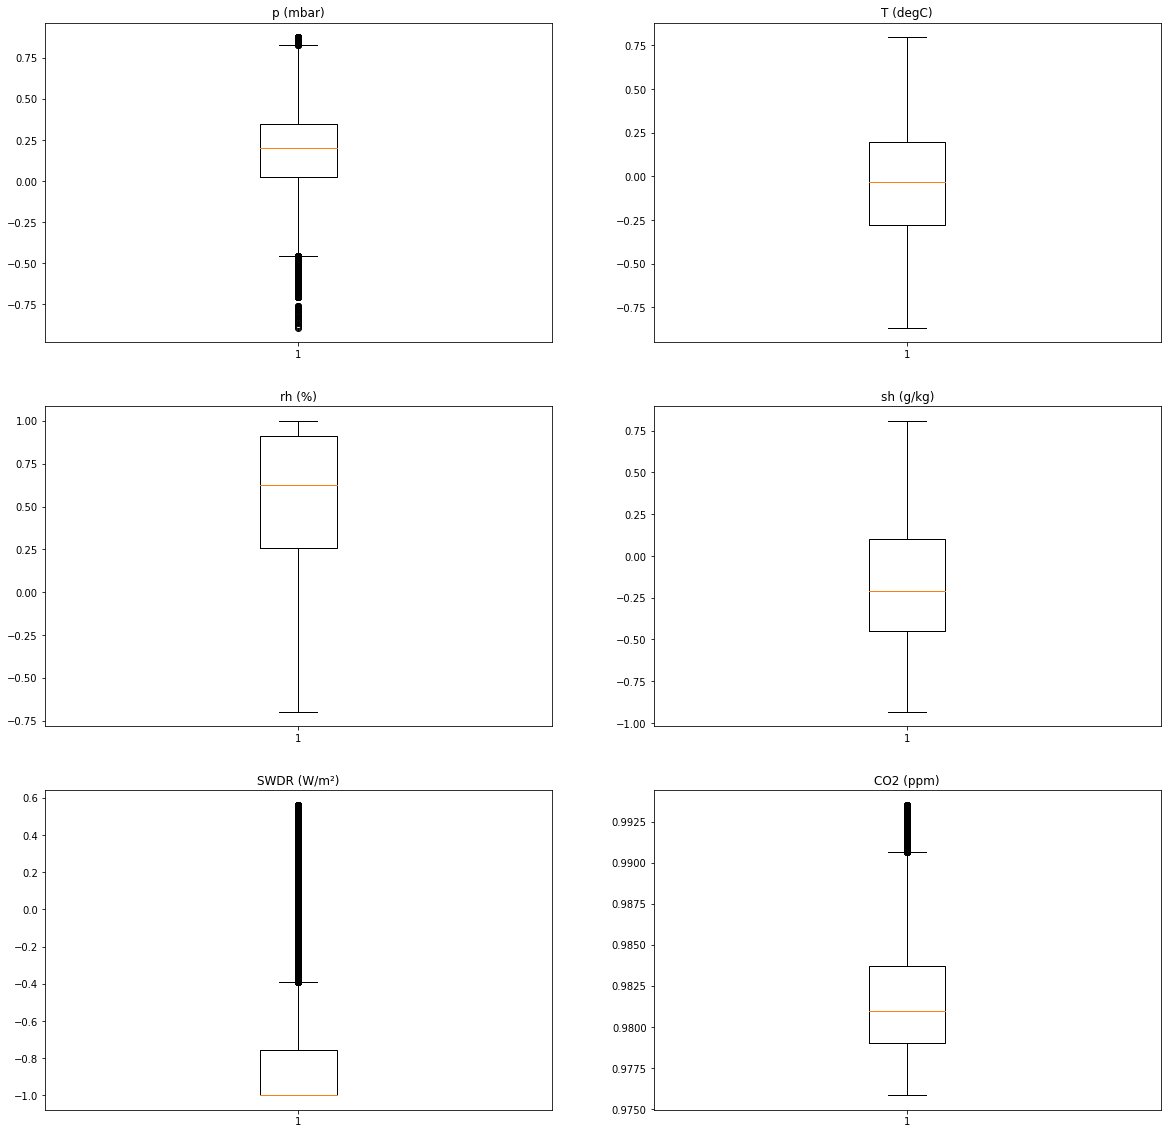

In [18]:
# print(train)
plot_boxplot(3,2,train,col_names,colors)

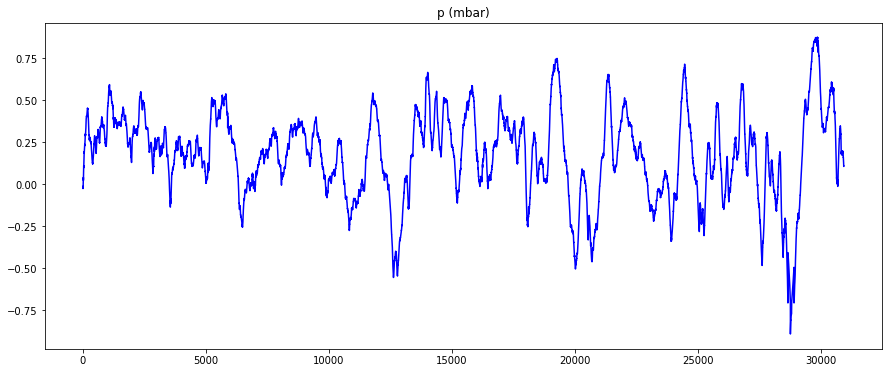

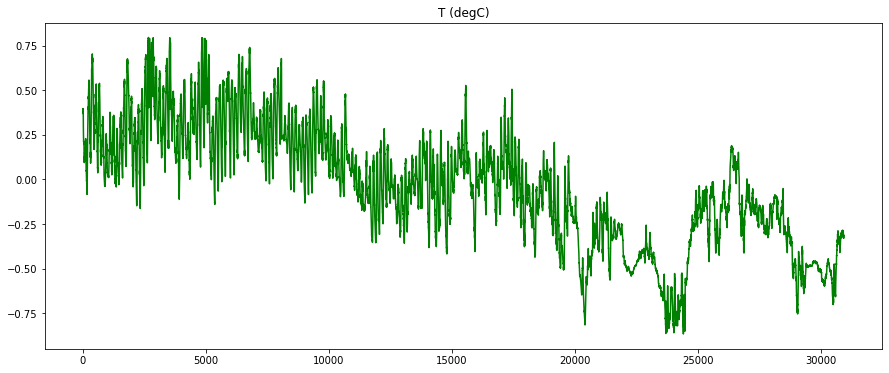

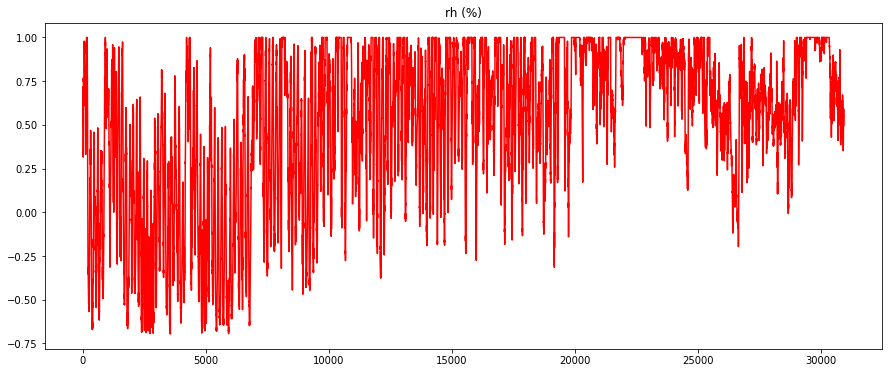

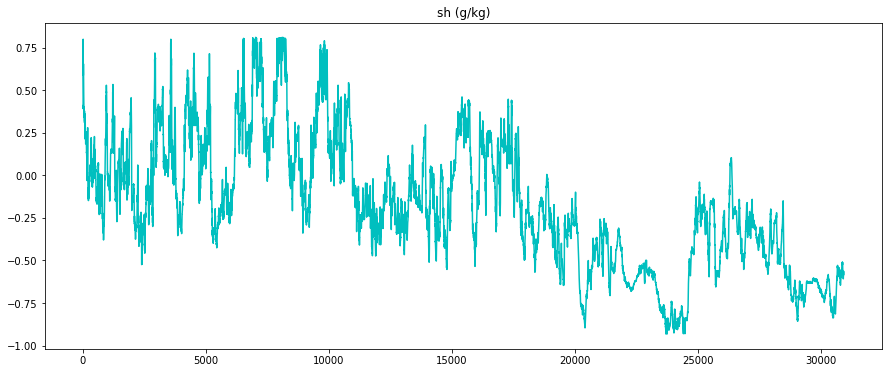

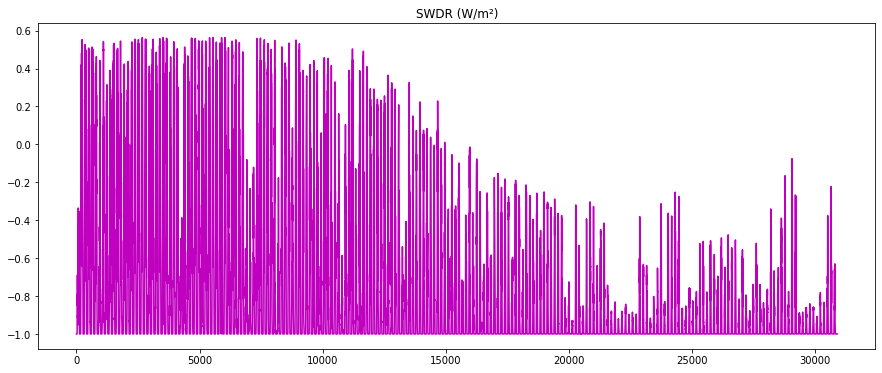

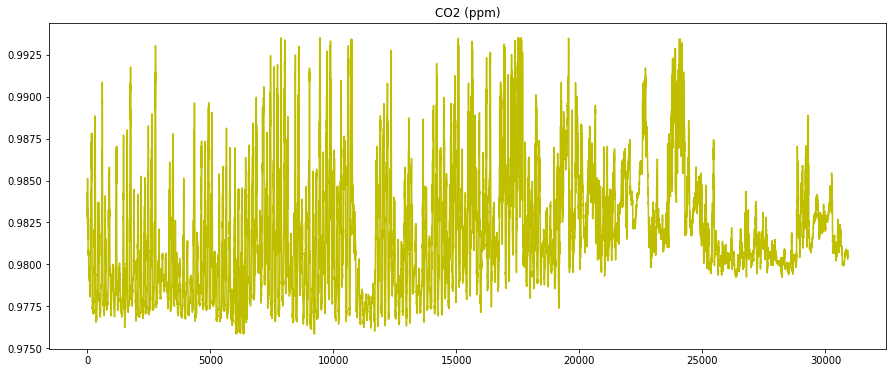

In [19]:
for i in range(train.shape[1]):
    plt.plot(train[:,i],color=colors[i])
    plt.title(col_names[i])
    plt.show()


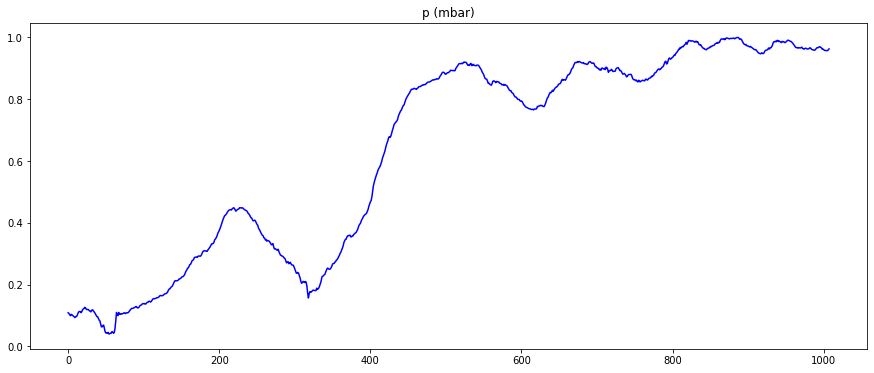

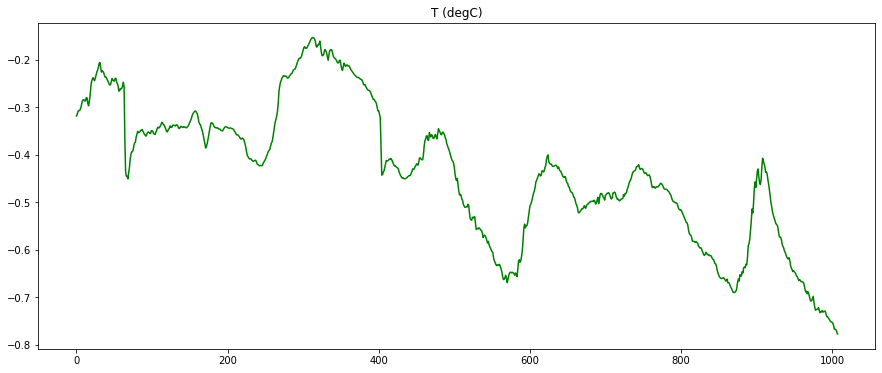

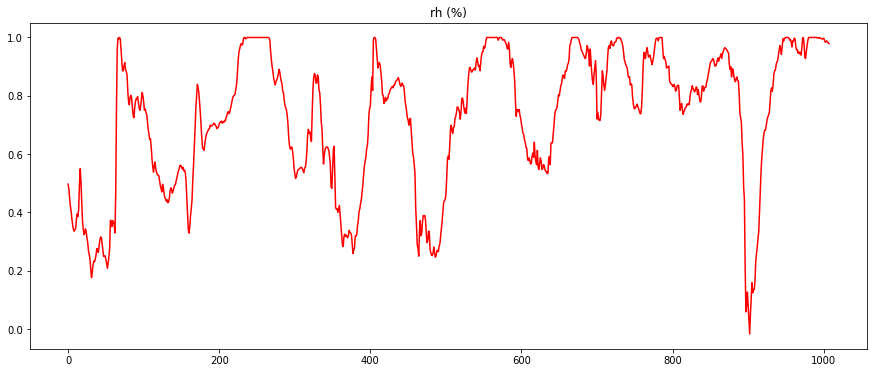

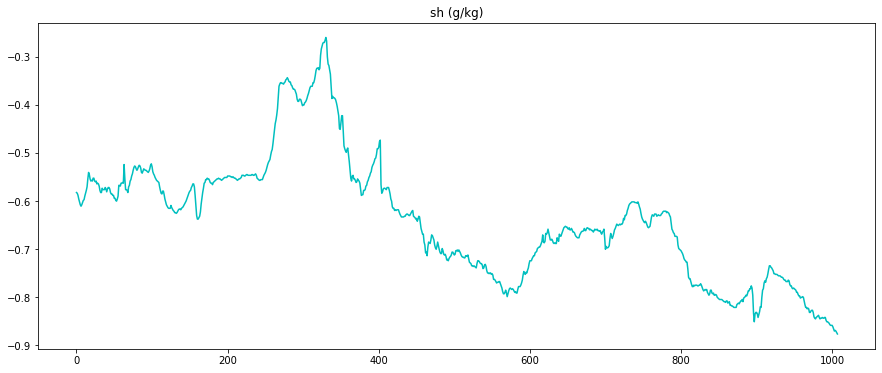

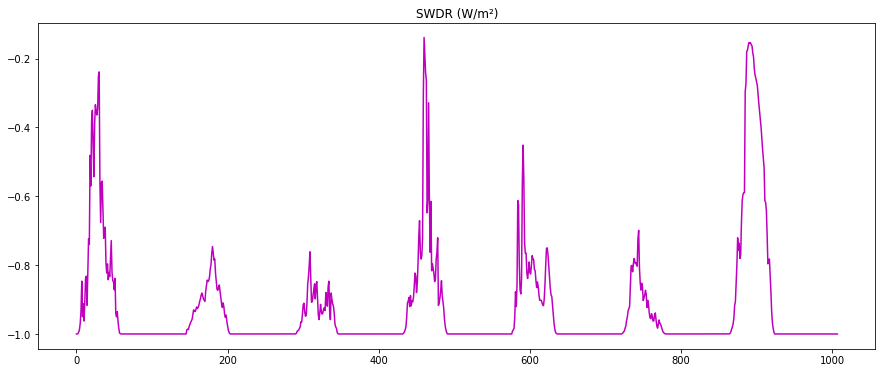

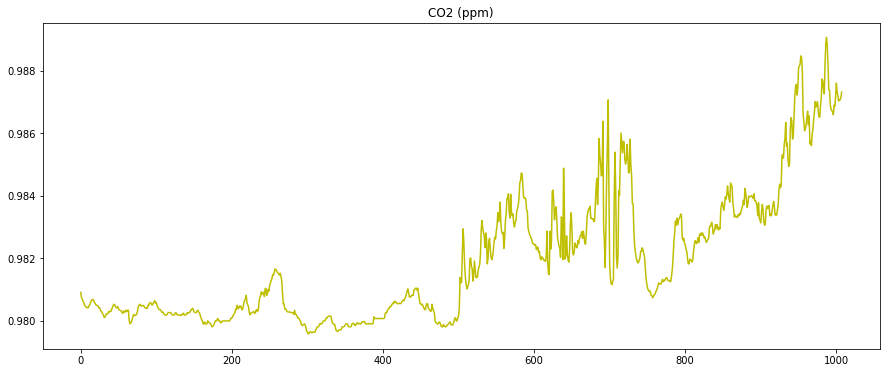

In [20]:
for i in range(test.shape[1]):
    plt.plot(test[:,i],color=colors[i])
    plt.title(col_names[i])
    plt.show()

In [21]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(0,len(sequences),n_steps_out):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [22]:
n_features = 6
n_months_in = 150
n_months_out = 100
X_train, y_train = split_sequences(train,n_months_in,n_months_out)
X_test, y_test = split_sequences(test,n_months_in,n_months_out)

In [23]:
# print(train[0:n_months_in+n_months_out,:])
# print("---------------------------------------------------------------")
# print(X_train[0:1,:])
# print("---------------------------------------------------------------")
# print(y_test[0:1,:])
# print("---------------------------------------------------------------")
print(train.shape)
print(test.shape)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(30922, 6)
(1008, 6)
(307, 150, 6) (307, 100, 6)
(8, 150, 6) (8, 100, 6)


In [24]:
y_train = y_train.reshape(y_train.shape[0],n_months_out*n_features)
y_test = y_test.reshape(y_test.shape[0],n_months_out*n_features)
print(y_train.shape)
print(y_test.shape)

(307, 600)
(8, 600)


In [25]:
# Define learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch % 150 == 0 and epoch > 0:
        lr = lr * 0.9    
    return lr

# early stopping and model chackpoint
learning_rate_scheduler = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor="val_loss",verbose=1,patience=100, mode="min",min_delta=0.00001)
model_checkpoint = ModelCheckpoint("best_model.h5",monitor="val_loss",verbose=1,save_best_only=True)


In [46]:
model = Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(n_months_in,n_features),recurrent_activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=False,recurrent_activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(n_months_out*n_features))


In [47]:
# 
model.compile(optimizer=Adam(learning_rate=0.00075), loss="mse")
epochs = 10000
validation_split = 0.3 # 30% validation set
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=147 ,verbose=1,validation_split=validation_split,shuffle=False, callbacks=[learning_rate_scheduler,early_stopping,model_checkpoint])

Epoch 1/10000
2/2 [==============================] - ETA: 0s - loss: 0.3930
Epoch 1: val_loss did not improve from 0.02734
2/2 [==============================] - 6s 1s/step - loss: 0.3930 - val_loss: 0.5151 - lr: 7.5000e-04
Epoch 2/10000
2/2 [==============================] - ETA: 0s - loss: 0.3918
Epoch 2: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 430ms/step - loss: 0.3918 - val_loss: 0.5137 - lr: 7.5000e-04
Epoch 3/10000
2/2 [==============================] - ETA: 0s - loss: 0.3906
Epoch 3: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 426ms/step - loss: 0.3906 - val_loss: 0.5123 - lr: 7.5000e-04
Epoch 4/10000
2/2 [==============================] - ETA: 0s - loss: 0.3895
Epoch 4: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 415ms/step - loss: 0.3895 - val_loss: 0.5109 - lr: 7.5000e-04
Epoch 5/10000
2/2 [==============================] - ETA: 0s - loss: 0.3883
Epoch 5: val_loss d

Epoch 37/10000
2/2 [==============================] - ETA: 0s - loss: 0.1589
Epoch 37: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 404ms/step - loss: 0.1589 - val_loss: 0.1134 - lr: 7.5000e-04
Epoch 38/10000
2/2 [==============================] - ETA: 0s - loss: 0.1447
Epoch 38: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 401ms/step - loss: 0.1447 - val_loss: 0.1133 - lr: 7.5000e-04
Epoch 39/10000
2/2 [==============================] - ETA: 0s - loss: 0.1362
Epoch 39: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 401ms/step - loss: 0.1362 - val_loss: 0.1157 - lr: 7.5000e-04
Epoch 40/10000
2/2 [==============================] - ETA: 0s - loss: 0.1295
Epoch 40: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 421ms/step - loss: 0.1295 - val_loss: 0.1155 - lr: 7.5000e-04
Epoch 41/10000
2/2 [==============================] - ETA: 0s - loss: 0.1253
Epoch 4

Epoch 73/10000
2/2 [==============================] - ETA: 0s - loss: 0.0870
Epoch 73: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 428ms/step - loss: 0.0870 - val_loss: 0.0419 - lr: 7.5000e-04
Epoch 74/10000
2/2 [==============================] - ETA: 0s - loss: 0.0852
Epoch 74: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 401ms/step - loss: 0.0852 - val_loss: 0.0414 - lr: 7.5000e-04
Epoch 75/10000
2/2 [==============================] - ETA: 0s - loss: 0.0860
Epoch 75: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 417ms/step - loss: 0.0860 - val_loss: 0.0409 - lr: 7.5000e-04
Epoch 76/10000
2/2 [==============================] - ETA: 0s - loss: 0.0856
Epoch 76: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 422ms/step - loss: 0.0856 - val_loss: 0.0397 - lr: 7.5000e-04
Epoch 77/10000
2/2 [==============================] - ETA: 0s - loss: 0.0833
Epoch 7

Epoch 109/10000
2/2 [==============================] - ETA: 0s - loss: 0.0583
Epoch 109: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 416ms/step - loss: 0.0583 - val_loss: 0.0364 - lr: 7.5000e-04
Epoch 110/10000
2/2 [==============================] - ETA: 0s - loss: 0.0571
Epoch 110: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 422ms/step - loss: 0.0571 - val_loss: 0.0338 - lr: 7.5000e-04
Epoch 111/10000
2/2 [==============================] - ETA: 0s - loss: 0.0554
Epoch 111: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 423ms/step - loss: 0.0554 - val_loss: 0.0331 - lr: 7.5000e-04
Epoch 112/10000
2/2 [==============================] - ETA: 0s - loss: 0.0554
Epoch 112: val_loss did not improve from 0.02734
2/2 [==============================] - 1s 401ms/step - loss: 0.0554 - val_loss: 0.0365 - lr: 7.5000e-04
Epoch 113/10000
2/2 [==============================] - ETA: 0s - loss: 0.053

2/2 [==============================] - ETA: 0s - loss: 0.0414
Epoch 144: val_loss did not improve from 0.02518
2/2 [==============================] - 1s 417ms/step - loss: 0.0414 - val_loss: 0.0259 - lr: 7.5000e-04
Epoch 145/10000
2/2 [==============================] - ETA: 0s - loss: 0.0410
Epoch 145: val_loss improved from 0.02518 to 0.02456, saving model to best_model.h5
2/2 [==============================] - 1s 454ms/step - loss: 0.0410 - val_loss: 0.0246 - lr: 7.5000e-04
Epoch 146/10000
2/2 [==============================] - ETA: 0s - loss: 0.0411
Epoch 146: val_loss improved from 0.02456 to 0.02378, saving model to best_model.h5
2/2 [==============================] - 1s 494ms/step - loss: 0.0411 - val_loss: 0.0238 - lr: 7.5000e-04
Epoch 147/10000
2/2 [==============================] - ETA: 0s - loss: 0.0404
Epoch 147: val_loss improved from 0.02378 to 0.02364, saving model to best_model.h5
2/2 [==============================] - 1s 463ms/step - loss: 0.0404 - val_loss: 0.0236 - lr

Epoch 179/10000
2/2 [==============================] - ETA: 0s - loss: 0.0356
Epoch 179: val_loss did not improve from 0.02363
2/2 [==============================] - 1s 427ms/step - loss: 0.0356 - val_loss: 0.0280 - lr: 6.7500e-04
Epoch 180/10000
2/2 [==============================] - ETA: 0s - loss: 0.0356
Epoch 180: val_loss did not improve from 0.02363
2/2 [==============================] - 1s 417ms/step - loss: 0.0356 - val_loss: 0.0277 - lr: 6.7500e-04
Epoch 181/10000
2/2 [==============================] - ETA: 0s - loss: 0.0359
Epoch 181: val_loss did not improve from 0.02363
2/2 [==============================] - 1s 423ms/step - loss: 0.0359 - val_loss: 0.0253 - lr: 6.7500e-04
Epoch 182/10000
2/2 [==============================] - ETA: 0s - loss: 0.0364
Epoch 182: val_loss did not improve from 0.02363
2/2 [==============================] - 1s 423ms/step - loss: 0.0364 - val_loss: 0.0250 - lr: 6.7500e-04
Epoch 183/10000
2/2 [==============================] - ETA: 0s - loss: 0.035

2/2 [==============================] - ETA: 0s - loss: 0.0328
Epoch 214: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 417ms/step - loss: 0.0328 - val_loss: 0.0246 - lr: 6.7500e-04
Epoch 215/10000
2/2 [==============================] - ETA: 0s - loss: 0.0301
Epoch 215: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 426ms/step - loss: 0.0301 - val_loss: 0.0254 - lr: 6.7500e-04
Epoch 216/10000
2/2 [==============================] - ETA: 0s - loss: 0.0320
Epoch 216: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 385ms/step - loss: 0.0320 - val_loss: 0.0250 - lr: 6.7500e-04
Epoch 217/10000
2/2 [==============================] - ETA: 0s - loss: 0.0318
Epoch 217: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 423ms/step - loss: 0.0318 - val_loss: 0.0268 - lr: 6.7500e-04
Epoch 218/10000
2/2 [==============================] - ETA: 0s - loss: 0.0317
Epoch 218: val

2/2 [==============================] - 1s 417ms/step - loss: 0.0294 - val_loss: 0.0276 - lr: 6.7500e-04
Epoch 250/10000
2/2 [==============================] - ETA: 0s - loss: 0.0291
Epoch 250: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 469ms/step - loss: 0.0291 - val_loss: 0.0292 - lr: 6.7500e-04
Epoch 251/10000
2/2 [==============================] - ETA: 0s - loss: 0.0309
Epoch 251: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 479ms/step - loss: 0.0309 - val_loss: 0.0280 - lr: 6.7500e-04
Epoch 252/10000
2/2 [==============================] - ETA: 0s - loss: 0.0306
Epoch 252: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 450ms/step - loss: 0.0306 - val_loss: 0.0249 - lr: 6.7500e-04
Epoch 253/10000
2/2 [==============================] - ETA: 0s - loss: 0.0308
Epoch 253: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 432ms/step - loss: 0.0308 - val_lo

2/2 [==============================] - ETA: 0s - loss: 0.0268
Epoch 285: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 455ms/step - loss: 0.0268 - val_loss: 0.0277 - lr: 6.7500e-04
Epoch 286/10000
2/2 [==============================] - ETA: 0s - loss: 0.0275
Epoch 286: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 486ms/step - loss: 0.0275 - val_loss: 0.0261 - lr: 6.7500e-04
Epoch 287/10000
2/2 [==============================] - ETA: 0s - loss: 0.0277
Epoch 287: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 479ms/step - loss: 0.0277 - val_loss: 0.0267 - lr: 6.7500e-04
Epoch 288/10000
2/2 [==============================] - ETA: 0s - loss: 0.0264
Epoch 288: val_loss did not improve from 0.02356
2/2 [==============================] - 1s 487ms/step - loss: 0.0264 - val_loss: 0.0281 - lr: 6.7500e-04
Epoch 289/10000
2/2 [==============================] - ETA: 0s - loss: 0.0267
Epoch 289: val

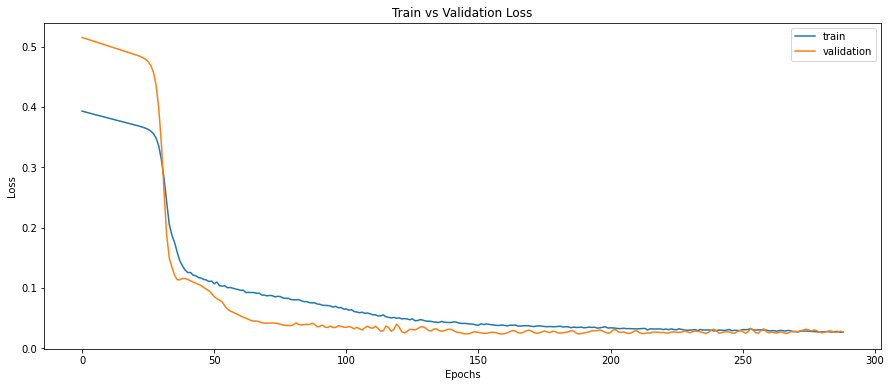

In [48]:
# plot the validation and training loss
plt.figure(figsize=(15,6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Train vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [49]:
# SAVE AND LOAD MODEL
# model.save("model2.h5")

# load model
model = load_model('best_model.h5')

In [50]:
# prediction
y_pred = np.zeros((y_test.shape[0],y_test.shape[1]))
X_test_model = X_test[0].copy()


# print(X_test[0],X_test.shape)
# print(X_test_model,X_test_model.shape)

In [51]:
for i in range(X_test.shape[0]):
    
#     print("Before\n")
#     print(X_test_model)
    X_test_model = X_test_model.reshape(1,n_months_in,n_features)
#     print("Before\n")
#     print(X_test_model)
    pred = model.predict(X_test_model, verbose=0)
    X_test_model.reshape(n_months_in,n_features)
#     print("Predicted\n")
#     print(pred)
#     print("Actual")
#     print(y_test[i])
    y_pred[i]=pred
#     print("y_pred all")
#     print(y_pred[i])
#     print("y_test all")
#     print(y_test[i])
    pred=pred.reshape(n_months_out,n_features)
#     print(pred)
    if(n_months_out>n_months_in):
        X_test_model[0,:] = pred[-n_months_in:]
    else:
        X_test_model[0,:-n_months_out] = X_test_model[0,n_months_out:]
        X_test_model[0,-n_months_out:] = pred

#     X_test_model[0,:-n_months_out] = X_test_model[0,n_months_out:]
#     X_test_model[0,-n_months_out:] = pred[-n_months_in:]
#     print("After")
#     print(X_test_model)
    


In [52]:
# y_pred = y_pred.reshape(y_test.shape[0],n_months_out*n_features)
# print(y_pred.shape)
y_pred_inv = np.zeros_like(y_pred)
y_test_inv = np.zeros_like(y_test)
for i in range(1,n_months_out+1):
#     print(i)
    y_pred_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_pred[:,(i-1)*n_features:i*n_features])
#     print(scaler.inverse_transform(y_pred[0:3,(i-1)*n_features:i*n_features]))
#     print("--------------------------------------------------------- i= ",i)
#     print(y_pred_inv[0:3,:])
#     print("--------------------------------------------------------- test")
    
    
    y_test_inv[:,(i-1)*n_features:i*n_features] = scaler.inverse_transform(y_test[:,(i-1)*n_features:i*n_features])
#     print(y_test_inv[0:10,:])
rmse = mean_squared_error(y_test_inv, y_pred_inv) ** (0.5)
print('Test RMSE: %.3f ' % rmse )

Test RMSE: 81.964 


In [53]:
y_test_re = y_test_inv.reshape(n_months_out*y_test_inv.shape[0], n_features)
y_pred_re = y_pred_inv.reshape(n_months_out*y_pred_inv.shape[0], n_features)
print(y_pred_re.shape)
print(y_test_re.shape)
rmse = mean_squared_error(y_test_re, y_pred_re) ** (0.5)
print('Test RMSE: %.3f ' % rmse )

(800, 6)
(800, 6)
Test RMSE: 81.964 


In [54]:
# print(y_pred_re[:10,])
# print(y_test_re[:10,])

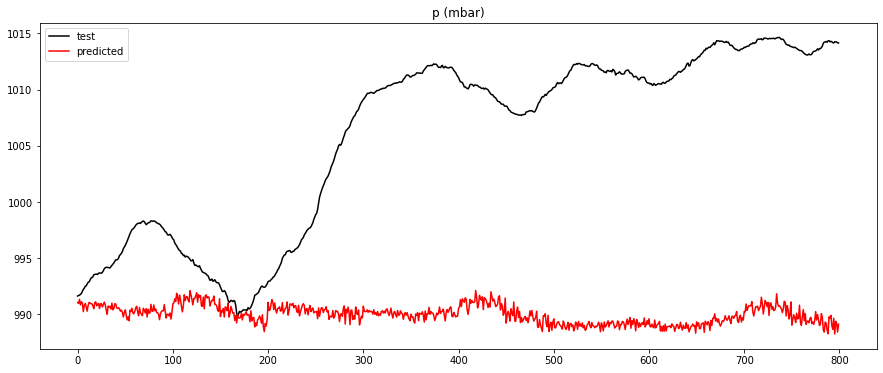

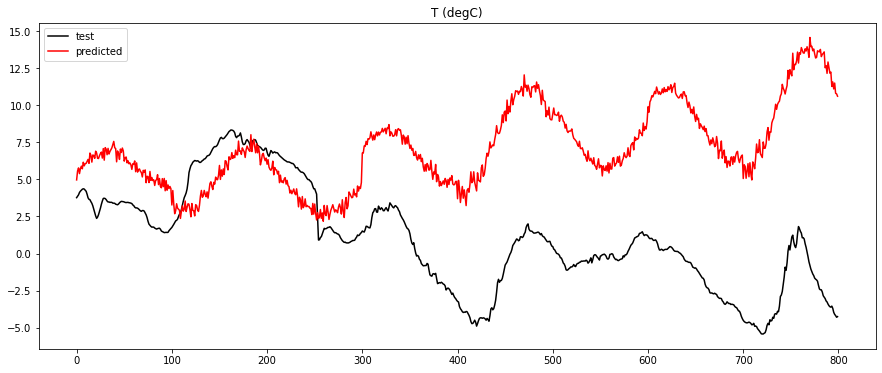

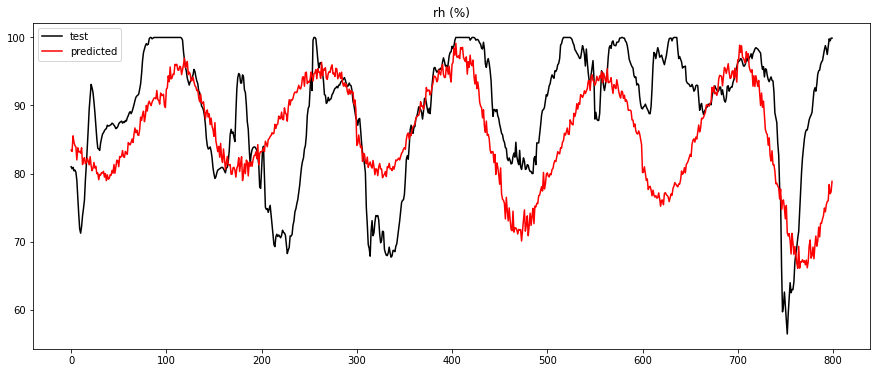

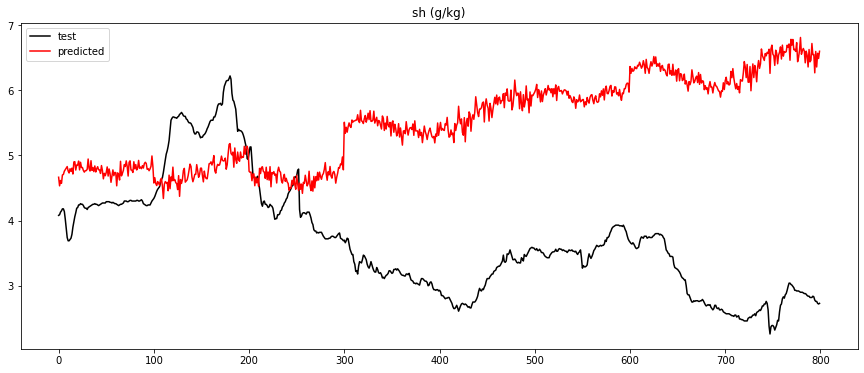

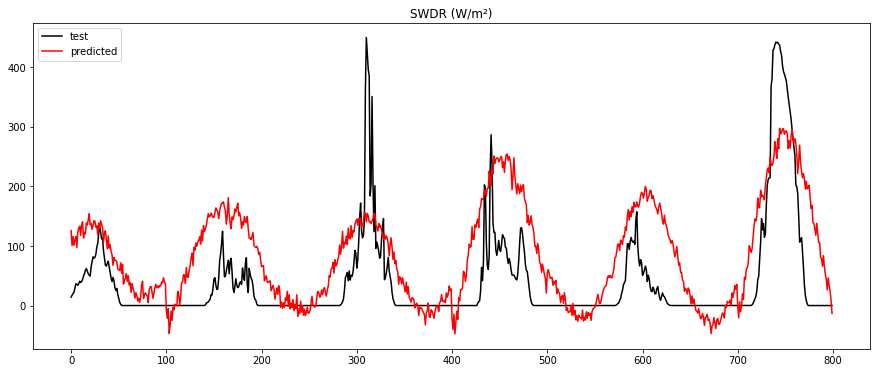

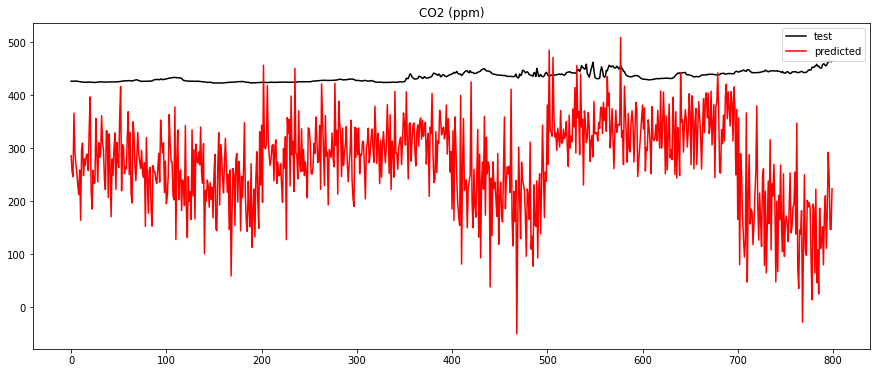

In [55]:
for i in range(n_features):
    plt.plot(y_test_re[:,i],color='black')
    plt.plot(y_pred_re[:,i],color='red')
    plt.legend(["test","predicted"])
    plt.title(col_names[i])
    plt.show()
